In [861]:
## import the required package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

## Data Description

The data contains the crimial history jail and prison time, demographics and COMPAS risk scores for defendants from Broward County from 2013 to 2014. The dataset we are using is compas-scores-two-years.csv.

In [842]:
## Read the file
df = pd.read_csv("/content/compas-scores-two-years.csv")

## Filter the data
df = df[(df["race"] == "African-American") | (df["race"] == "Caucasian")]

## Change the race entry
df["race"] = np.where(df["race"] == "African-American", 0, 1)

## We drop attributes that is clearly independent with the two_year_recid, ie. name, id, r_case_number, c_case_number,
## as well as the attribute with all NaN value
## as well as the duplicate columns
df.drop(["id", "name", "first", "last", "r_case_number", "c_case_number",
         "violent_recid",
         "decile_score.1", "priors_count.1"],
        axis = 1, inplace=True)

In [843]:
## We drop the column with the number of NaN value exceed 1000
df.drop(["vr_charge_desc", "vr_offense_date",
        "vr_charge_degree", "vr_case_number", "c_arrest_date",
        "c_arrest_date", "r_jail_out", "r_jail_in", "r_days_from_arrest",
        "r_charge_desc", "r_charge_degree", "r_offense_date"],
        axis = 1, inplace=True)

## Remove the rows with NaN
df.dropna(inplace=True)

## we also drop the columns represent the date
df.drop(['compas_screening_date', 'dob', 'c_jail_in', 'c_jail_out',
         'c_offense_date', 'screening_date', 'v_screening_date',
         'in_custody', 'out_custody'],
        axis = 1, inplace=True)

## We drop the somehow repeated attribute, age_cat, score_text, v_score_text
df.drop(['age_cat', 'score_text', 'v_score_text'],
        axis = 1, inplace=True)

## Set sex into 0 or 1, c_charge_degree into 0 or 1
df["sex"] = np.where(df["sex"] == "Male", 0, 1)
df["c_charge_degree"] = np.where(df["c_charge_degree"] == "M", 0, 1)

## Drop the column with only 1 input or too many category
df.drop(['type_of_assessment', 'v_type_of_assessment', 'c_charge_desc'],
        axis = 1, inplace=True)

In [841]:
np.unique(df['c_charge_degree'])

array(['F', 'M'], dtype=object)

In [891]:
df.head(5)

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,c_charge_degree,is_recid,is_violent_recid,v_decile_score,start,end,event,two_year_recid
1,0,34,0,0,3,0,0,0,-1.0,1.0,1,1,1,1,9,159,1,1
2,0,24,0,0,4,0,1,4,-1.0,1.0,1,1,0,3,0,63,0,1
6,0,41,1,0,6,0,0,14,-1.0,1.0,1,1,0,2,5,40,1,1
8,1,39,1,0,1,0,0,0,-1.0,1.0,0,0,0,1,2,747,0,0
9,0,21,1,0,3,0,0,1,428.0,308.0,1,1,1,5,0,428,1,1


## Baseline Model

We use a Boosting model

In [868]:
scaler = StandardScaler()
X, y = df.drop("two_year_recid", axis = 1, inplace = False), df.two_year_recid
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=5243)


baseline = LogisticRegression(random_state=5243,max_iter=1000)

baseline.fit(X_train, y_train)
preds = baseline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

preds_all = baseline.predict(X_scaled)
accuracy = sum(y == preds_all)/len(y)
print("Accuracy: %f" % (accuracy))

RMSE: 0.109654
Accuracy: 0.985568


## Paper 1: Handling Conditional Discrimination

This paper handle with discrimination introduced by sensitive parameter, here "race".

### Background

The bias that caused by discrimination can be distribute to two part:
- discrimination caused by the sensitive attribute itself $D_{bad}$
- the discrimination caused by the attributes that are correlated to the sensitive attribute $D_{expl}$.

*Notice* : the attribute that are correlated to the sensitive attribute and also gives some objective information to the label y is called **explanatory attribute**.

In summary, $D_{all}=D_{bad}+D_{expl}$.

### Objective of the paper

- minimize the absolute value of $D_{bad}$
- keeping the accuracy as high as possible

### Method

To be discrimination free, we should control:
- $P_c(+|e_i, race = 0) = P_c(+|e_i, race = 1)$, where $e_i$ is the explanatory attribute and $P(+)=P(y=+1)$
- $P_c(+|e_i) = P_c^\star(+|e_i)$, where $P_c^\star(+|e_i):=\frac{P_c(+|e_i, race=1)+P_c(+|e_i, race=0)}{2}$

To achieve it, the paper introduced two methods: Local Massaging and Local Preferential Sampling.

###  *Local Massaging*

Modify the value of y until $P_c'(+|e_i, race = 0)=P_c'(+|e_i, race = 1)=P_c^\star(+|e_i)$ by identifing the instances that are close to the decision boundary and changes the values of their labels to the opposite.

Convert the original binary label y into real valued probabilities of defendant recidivated within two year, and sort the value. Change the lable of individuals that are almost recidivated within two year or almost not recidivated within two year to opposite.

### *Local Preferential Sampling*

This method modifies the composition of the training set. It deletes and duplicates training instances such that the modified training set satisty $P_c'(+|e_i, race = 0)=P_c'(+|e_i, race = 1)=P_c^\star(+|e_i)$.

To achieve it, it deletes the ‘wrong’ instances that are close to the decision boundary and duplicates the instances that are ‘right’ and close to the boundary.

In [869]:
## Calculate D_{all}
def D_all_func(data = df):
  P_y1r1 = len(data[(data["two_year_recid"] == 1) & (data["race"] == 1)])/len(data)
  P_y1r0 = len(data[(data["two_year_recid"] == 1) & (data["race"] == 0)])/len(data)
  D_all = P_y1r0-P_y1r1
  return(D_all)

D_all = D_all_func()
D_all

0.15073160954099016

In [904]:
expl = ['sex', 'age', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_days_from_compas', 'c_charge_degree', 'is_recid', 'is_violent_recid',
       'v_decile_score', 'start', 'end', 'event']

## Calculate D_bad
def D_bad_func(data = df, y_col = "two_year_recid", expl_col = expl):

  '''
  This function take a data frame, the name of the y column and a list of explanatory attribute as input
  Then output a dictionary of D_{expl}
  '''

  D_bad = dict()
  for i in expl_col:
    P_star_i = df.groupby(['race', i])[y_col].mean().unstack(fill_value=0).mean()
    expl_counts = df.groupby(['race', i]).size().unstack(fill_value=0)
    race_counts = df['race'].value_counts()
    P_e_r = expl_counts.div(race_counts, axis=0)
    P_e_r_diff =  P_e_r.loc[0] - P_e_r.loc[1]
    D_bad_i = D_all - (P_e_r_diff * P_star_i).sum()
    D_bad[i] = D_bad_i

  return(D_bad)

D_bad_baseline = D_bad_func()

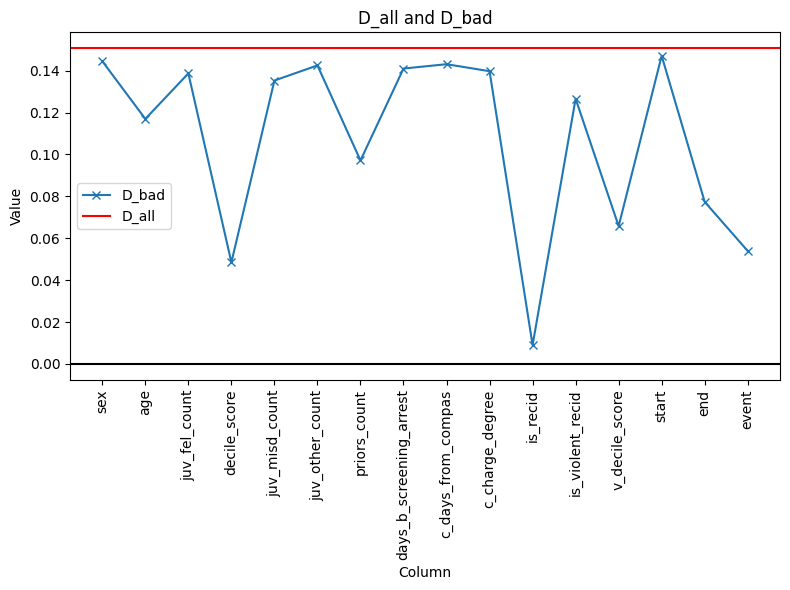

In [880]:
## Plot the graph of D_{all} and D_{bad}
def plot_D(D_bad):
  df_plot = pd.DataFrame({
      'Column': D_bad.keys(),
      'D_bad': D_bad.values()
  })
  plt.figure(figsize=(8, 6))

  # Plot D_{expl} and D_{all}
  plt.plot(df_plot['Column'], df_plot['D_bad'], marker='x', label='D_bad')
  plt.axhline(y=D_all, color='r', linestyle='-', label='D_all')
  plt.axhline(y=0, color='black', linestyle='-')
  plt.title('D_all and D_bad')
  plt.xlabel('Column')
  plt.ylabel('Value')
  plt.xticks(rotation=90)
  plt.legend()
  plt.tight_layout()
  plt.show()

plot_D(D_bad_baseline)

As we can see on the plot, `is_recid` have the highest $D_{expl}$ in absolute value. Other attributes such as `decile_score`, `score_text`, `_decile_score` and `event` also have a relatively high $D_{expl}$.

## *Local preferential sampling*

We choose `is_recid` to be the explanatory attribute.

In [872]:
def delta(partition_data, r):
  P_race_1 = partition_data[partition_data.race == 1].two_year_recid.mean()
  P_race_0 = partition_data[partition_data.race == 0].two_year_recid.mean()
  P_star = (P_race_1 + P_race_0) / 2
  P_race = partition_data[partition_data.race == r].two_year_recid.mean()
  G = len(partition_data[partition_data.race == r])
  delta_val = G * abs(P_star - P_race)
  return (delta_val)

In [900]:
def LocalPreferentialSampling(expl_str, data = df, drop_c = ["two_year_recid", "race"]):
  new_df = data.copy()
  for i in np.unique(new_df[expl_str]):
    partition = df[df[expl_str] == i].copy()
    for r in (0, 1):
      D = delta(partition, r)
      if D > 1:
        race = partition[partition['race'] == r].copy()
        X_race = race.drop(drop_c, axis = 1, inplace = False)
        X_race_scaled = scaler.fit_transform(X_race)
        ## Learn a ranker
        ranker = LogisticRegression(random_state=5243,max_iter=200)

        ranker.fit(X_race_scaled, race.two_year_recid)
        race['rank'] = ranker.predict_proba(X_race_scaled)[:, 1]

        ## we should increase the number of y = + to race = 1
        race_0 = race[race['two_year_recid'] == 0].sort_values(by='rank')
        race_1 = race[race['two_year_recid'] == 1].sort_values(by='rank')
        cloest_0 = race_0.head((int(1/2 * D))).drop(columns = 'rank')
        cloest_1 = race_1.tail((int(1/2 * D))).drop(columns = 'rank')
        if r == 0:
          new_df.drop(cloest_1.index, inplace = True)
          new_df = pd.concat([new_df, cloest_0], ignore_index=False)
        else:
          new_df.drop(cloest_0.index, inplace = True)
          new_df = pd.concat([new_df, cloest_1], ignore_index=False)
  return(new_df)

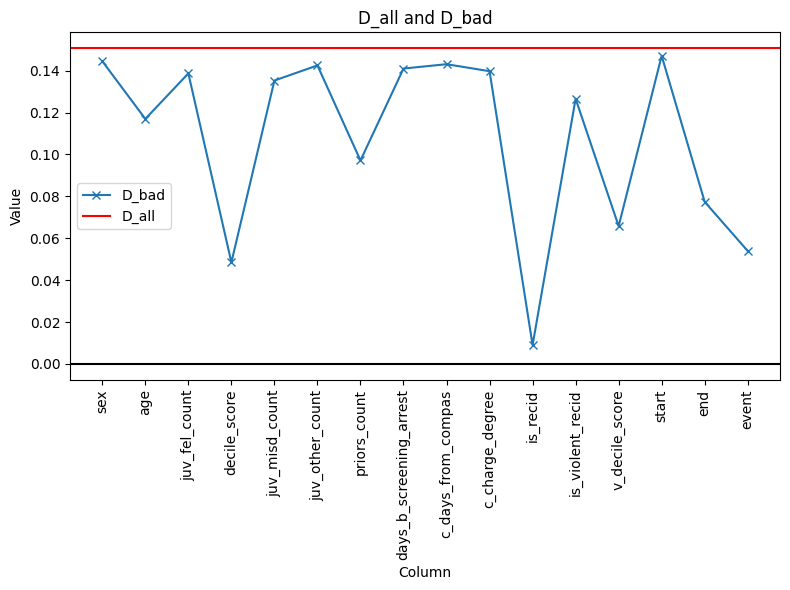

In [901]:
df_lps = LocalPreferentialSampling('is_recid', data = df)
D_bad_lps = D_bad_func(data = df_lps, expl_col=expl)
plot_D(D_bad_baseline)

In [894]:
D_bad_baseline

{'sex': 0.14449874108408947,
 'age': 0.11694092978810877,
 'juv_fel_count': 0.13866290620847282,
 'decile_score': 0.04847439933559032,
 'juv_misd_count': 0.13526174663175625,
 'juv_other_count': 0.14248166297381487,
 'priors_count': 0.09709572437429237,
 'days_b_screening_arrest': 0.1409883896565128,
 'c_days_from_compas': 0.14305419418033577,
 'c_charge_degree': 0.13972025723445752,
 'is_recid': 0.008994536459829144,
 'is_violent_recid': 0.12655636684714705,
 'v_decile_score': 0.0657739680913049,
 'start': 0.1470428601796604,
 'end': 0.07733788660452315,
 'event': 0.05391771804161927}

In [883]:
D_bad_lps

{'sex': 0.14434077000891649,
 'age': 0.1178516451372681,
 'juv_fel_count': 0.13790351307241874,
 'decile_score': 0.04821619225614543,
 'juv_misd_count': 0.13361912397082285,
 'juv_other_count': 0.14178341967979824,
 'priors_count': 0.09485268123326726,
 'days_b_screening_arrest': 0.13982815351539504,
 'c_days_from_compas': 0.1418360211776231,
 'c_charge_degree': 0.13922128559112232,
 'is_recid': -0.008544929100544135,
 'is_violent_recid': 0.12313350730258818,
 'v_decile_score': 0.06643141197638898,
 'start': 0.14558709347096385,
 'end': 0.06286684317722914,
 'event': 0.03942827097322574}

As we can see from the plot, it seems the improvement is very limit after applying the algorithm.

In [902]:
## Change in accuracy
X_lps, y_lps = df_lps.drop("two_year_recid", axis = 1, inplace = False), df_lps.two_year_recid
X_lps = scaler.fit_transform(X_lps)

model_lps = LogisticRegression(random_state=5243,max_iter=1000)
model_lps.fit(X_lps, y_lps)
preds_all_lps = model_lps.predict(X_lps)
accuracy_lps = sum(y_lps == preds_all_lps)/len(y_lps)

print("Accuracy: %f" % (accuracy))
print("LPS Accuracy: %f" % (accuracy_lps))

Accuracy: 0.985568
LPS Accuracy: 0.985969


Meanwhile, the accuracy increase by a very small amount.